In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
import os
import random
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib 
from sklearn.model_selection import KFold

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2500131362376772425
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9857662976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13680961026036154970
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './Dataset/Train/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = ImageDataGenerator(rescale=1./255)
validation_generator = validation_generator.flow_from_directory(
    './Dataset/Test/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    './dataset/validation/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 1927 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 168 images belonging to 4 classes.
{'busuk': 0, 'matang': 1, 'mentah': 2, 'setengah matang': 3}
{'busuk': 0, 'matang': 1, 'mentah': 2, 'setengah matang': 3}
{'busuk': 0, 'matang': 1, 'mentah': 2, 'setengah matang': 3}


In [16]:
model = tf.keras.models.Sequential([
    #konvolusi pertama
    # Depth 16, kernel size 3x3 matrix
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #konvolusi kedua
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #konvolusi ketiga
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #flatten dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    #fully connected layers
    tf.keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(4, activation='softmax')    #ubah dense dari 6 menjadi 4 (tf.keras.layers.Dense(4, activation='softmax'))
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# history = model.fit(
#     train_generator, steps_per_epoch=3, epochs=200, validation_data=validation_generator, validation_steps=3
# )



In [17]:
batch_size = 32
epochs = 100
image_height = 256
image_width = 256
num_classes = 4
n_splits = 5


# Use ImageDataGenerator to load images from directories and perform data augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Get the list of all image filenames and their corresponding labels
class_names = sorted(os.listdir(data_dir))
image_filenames = []
labels = []
for i, class_name in enumerate(class_names, 1):  # Enumerate from 1
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        image_filenames.append(os.path.join(class_dir, filename))
        labels.append(i)

image_filenames = np.array(image_filenames)
labels = np.array(labels)

# Define KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True)

# Perform cross-validation
fold_accuracy = []
fold_loss = []
for train_index, val_index in kf.split(image_filenames):
    x_train, x_val = image_filenames[train_index], image_filenames[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create train and validation generators
    train_generator = datagen.flow_from_directory(
        './Dataset2/Train',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')  # Specify subset as 'training' for training data

    validation_generator = datagen.flow_from_directory(
        './Dataset2/Validation',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')  # Specify subset as 'validation' for validation data

    # Train the model
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    # Evaluate the model on validation data
    loss, accuracy = model.evaluate(validation_generator)
    fold_loss.append(loss)
    fold_accuracy.append(accuracy)

# Display cross-validation results
print(f"Cross-Validation Results ({n_splits}-fold):")
for i in range(n_splits):
    print(f"Fold {i+1}: Loss = {fold_loss[i]}, Accuracy = {fold_accuracy[i]}")

Found 1927 images belonging to 4 classes.
Found 168 images belonging to 4 classes.
Epoch 1/100
61/61 [==============================] - 5s 69ms/step - loss: 0.4776 - accuracy: 0.8568 - val_loss: 0.1206 - val_accuracy: 1.0000
Epoch 2/100
61/61 [==============================] - 4s 66ms/step - loss: 0.1227 - accuracy: 0.9995 - val_loss: 0.0682 - val_accuracy: 1.0000
Epoch 3/100
61/61 [==============================] - 4s 66ms/step - loss: 0.0912 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 1.0000
Epoch 4/100
61/61 [==============================] - 4s 66ms/step - loss: 0.0741 - accuracy: 0.9995 - val_loss: 0.0473 - val_accuracy: 1.0000
Epoch 5/100
61/61 [==============================] - 4s 66ms/step - loss: 0.0626 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 1.0000
Epoch 6/100
61/61 [==============================] - 4s 68ms/step - loss: 0.0581 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 1.0000
Epoch 7/100
61/61 [==============================] - 4s 67ms/step

KeyboardInterrupt: 

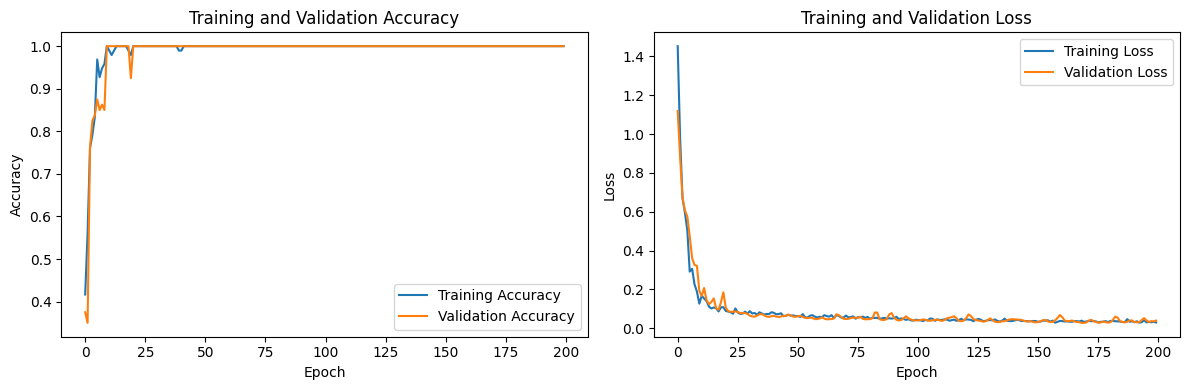

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

6/6 [==============================] - 1s 168ms/step


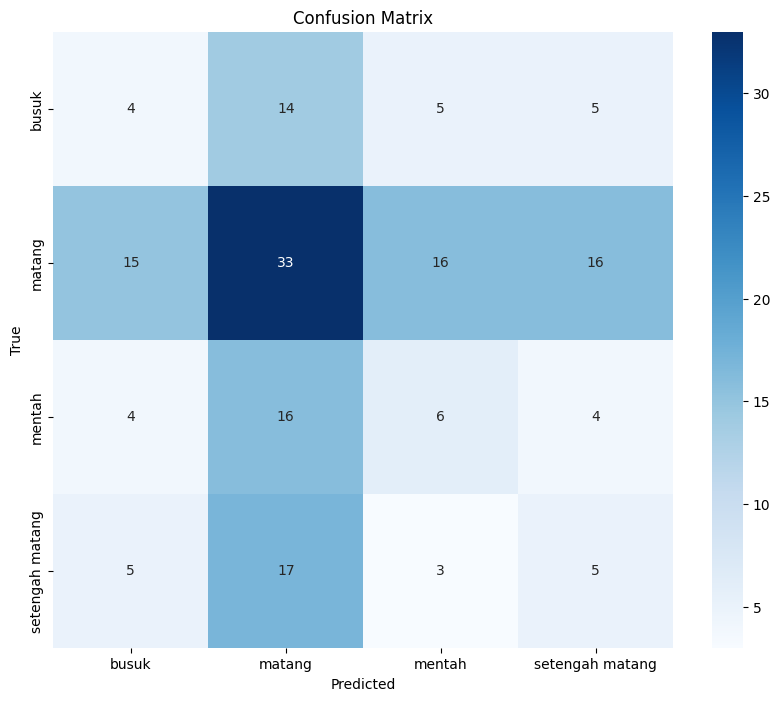

In [ ]:
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(class_report)

6/6 [==============================] - 0s 49ms/step
Confusion Matrix:
[[ 5 15  3  5]
 [13 40 15 12]
 [ 2 13  8  7]
 [ 8 12  4  6]]
Classification Report:
                 precision    recall  f1-score   support

          busuk       0.18      0.18      0.18        28
         matang       0.50      0.50      0.50        80
         mentah       0.27      0.27      0.27        30
setengah matang       0.20      0.20      0.20        30

       accuracy                           0.35       168
      macro avg       0.29      0.29      0.29       168
   weighted avg       0.35      0.35      0.35       168



In [ ]:
# Save the Trained Model
model.save('trained_model.h5')
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpc3xbrbz6\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpc3xbrbz6\assets
